# Class 1: Introduction and setting up a simple LCA calculation

Note: this notebook is based on [Brightway2 tutorial 4 - meta-analysis](http://nbviewer.ipython.org/urls/bitbucket.org/cmutel/brightway2/raw/2.0/notebooks/Tutorial%204%20-%20Meta-analysis.ipynb).

# Setup

Import the necessary libraries

In [1]:
from brightway2 import *
import numpy as np
import pyprind
from scipy import stats
import random

Set a new project for this class session

In [2]:
projects.current = "Class 1 new"

Import the basic biosphere and LCIA methods (requires internet connection)

In [3]:
bw2setup()

Creating default biosphere

Applying strategy: normalize_units

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 0.598 sec



Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.01 seconds
Title: Writing activities to SQLite3 database:
  Started: 09/22/2015 11:24:14
  Finished: 09/22/2015 11:24:15
  Total time elapsed: 0.598 sec
  CPU %: 90.800000
  Memory %: 1.275301
Created database: biosphere3
Creating default LCIA methods

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 4 strategies in 1.70 seconds
Wrote 692 LCIA methods with 170915 characterization factors
Creating core data migrations



# Import ecoinvent 2.2

We are using version 2.2 to make the calculations a bit quicker, as this is intended to be run during the class.

First, extract the data from the XML files.

In [4]:
ei = SingleOutputEcospold1Importer("/Users/cmutel/Documents/LCA Documents/Ecoinvent/2.2/processes", "ecoinvent 2.2")

Extracting ecospold1 files:
0%                          100%
[##############################] | ETA[sec]: 0.000 | Item ID: /Users/cmutel/D
Total time elapsed: 11.087 sec


Title: Extracting ecospold1 files:
  Started: 09/22/2015 11:26:13
  Finished: 09/22/2015 11:26:24
  Total time elapsed: 11.087 sec
  CPU %: 89.000000
  Memory %: 3.367233
Extracted 4087 datasets in 11.23 seconds


In [ ]:
ei = SingleOutputEcospold1Importer("c:\\Users\\cmutel\\Process_infra_roh", "ecoinvent 2.2")

Next, we normalize some values, and link the different datasets to each other and the basic biosphere

In [5]:
ei.apply_strategies()

Applying strategy: normalize_units
Applying strategy: assign_only_product_as_production
Applying strategy: clean_integer_codes
Applying strategy: drop_unspecified_subcategories
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: link_technosphere_by_activity_hash
Applied 10 strategies in 4.42 seconds


Check to make sure everything is linked

In [6]:
ei.statistics()

4087 datasets
135892 exchanges
0 unlinked exchanges
  


(4087, 135892, 0)

Finally, write the database

In [7]:
ei.write_database()

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 19.891 sec


Title: Writing activities to SQLite3 database:
  Started: 09/22/2015 11:30:11
  Finished: 09/22/2015 11:30:31
  Total time elapsed: 19.891 sec
  CPU %: 86.900000
  Memory %: 3.523302
Created database: ecoinvent 2.2


Brightway2 SQLiteBackend: ecoinvent 2.2

In [8]:
list(databases)

['ecoinvent 2.2', 'biosphere3']

In [9]:
list(methods)

[('ecological scarcity 2006', 'total', 'total'),
 ('selected LCI results, additional', 'air', 'zinc'),
 ('EDIP', 'environmental impact', 'human toxicity, via soil'),
 ('CML 2001 w/o LT', 'climate change w/o LT', 'upper limit of net GWP w/o LT'),
 ('ReCiPe Midpoint (E) w/o LT', 'marine ecotoxicity w/o LT', 'METPinf w/o LT'),
 ('CML 2001', 'photochemical oxidation (summer smog)', 'MIR'),
 ('EDIP2003 w/o LT', 'non-renewable resources w/o LT', 'zinc w/o LT'),
 ('CML 2001', 'freshwater aquatic ecotoxicity', 'FAETP 500a'),
 ('cumulative exergy demand',
  'biomass',
  'renewable energy resources, biomass'),
 ('eco-indicator 99, (H,A) w/o LT',
  'human health w/o LT',
  'respiratory effects w/o LT'),
 ('EDIP2003', 'non-renewable resources', 'natural gas'),
 ('EDIP2003 w/o LT',
  'stratospheric ozone depletion w/o LT',
  'ODP total w/o LT'),
 ('CML 2001', 'marine aquatic ecotoxicity', 'MAETP infinite'),
 ('ReCiPe Midpoint (E)', 'ozone depletion', 'ODPinf'),
 ('EDIP2003', 'non-renewable resource

# Do some calculations

We select the new database we just created, and then use a bit of trickiness to get random ordering. All datasets have the ``type`` ``"process"``, so this is equivalent to random ordering.

In [10]:
db = Database("ecoinvent 2.2")
db.order_by = "type"

Many of the built-in LCIA methods are too narrowly focused - we pre-select a set of candidates to use for our meta-calculations.

In [11]:
CANDIDATES = sorted([
 (u'CML 2001', u'acidification potential', u'average European'),
 (u'CML 2001', u'climate change', u'GWP 100a'),
 (u'CML 2001', u'eutrophication potential', u'average European'),
 (u'CML 2001', u'freshwater aquatic ecotoxicity', u'FAETP 100a'),
 (u'CML 2001', u'human toxicity', u'HTP 100a'),
 (u'CML 2001', u'land use', u'competition'),
 (u'CML 2001', u'marine aquatic ecotoxicity', u'MAETP infinite'),
 (u'CML 2001', u'resources', u'depletion of abiotic resources'),
 (u'CML 2001', u'stratospheric ozone depletion', u'ODP 25a'),
 (u'EDIP2003', u'ecotoxicity', u'in sewage treatment plants'),
 (u'EDIP2003', u'eutrophication', u'terrestrial eutrophication'),
 (u'EDIP2003', u'renewable resources', u'wood'),
 (u'EDIP2003', u'stratospheric ozone depletion', u'ODP total'),
 (u'EPS 2000', u'total', u'abiotic stock resources'),
 (u'EPS 2000', u'total', u'emissions into soil'),
 (u'EPS 2000', u'total', u'emissions into water'),
 (u'EPS 2000', u'total', u'land occupation'),
 (u'IMPACT 2002+ (Endpoint)', u'ecosystem quality', u'land occupation'),
 (u'IMPACT 2002+ (Endpoint)', u'human health', u'ozone layer depletion'),
 (u'IMPACT 2002+ (Endpoint)', u'resources', u'mineral extraction'),
 (u'IMPACT 2002+ (Endpoint)', u'resources', u'non-renewable energy'),
 (u'IMPACT 2002+ (Midpoint)', u'ecosystem quality', u'aquatic acidification'),
 (u'IPCC 2001', u'climate change', u'GWP 100a'),
 (u'ReCiPe Endpoint (H,A)',
  u'ecosystem quality',
  u'agricultural land occupation'),
 (u'ReCiPe Endpoint (H,A)',
  u'ecosystem quality',
  u'freshwater eutrophication'),
 (u'ReCiPe Endpoint (H,A)',
  u'ecosystem quality',
  u'natural land transformation'),
 (u'ReCiPe Endpoint (H,A)',
  u'ecosystem quality',
  u'terrestrial acidification'),
 (u'ReCiPe Endpoint (H,A)', u'ecosystem quality', u'urban land occupation'),
 (u'ReCiPe Endpoint (H,A)', u'human health', u'particulate matter formation'),
 (u'ReCiPe Endpoint (H,A)', u'resources', u'fossil depletion'),
 (u'TRACI', u'environmental impact', u'acidification'),
 (u'TRACI', u'environmental impact', u'eutrophication'),
 (u'TRACI', u'environmental impact', u'global warming'),
 (u'TRACI', u'environmental impact', u'ozone depletion'),
 (u'TRACI', u'human health', u'respiratory effects, average'),
 (u'eco-indicator 99, (H,A)',
  u'ecosystem quality',
  u'acidification & eutrophication'),
 (u'eco-indicator 99, (H,A)', u'ecosystem quality', u'ecotoxicity'),
 (u'eco-indicator 99, (H,A)', u'ecosystem quality', u'land occupation'),
 (u'eco-indicator 99, (H,A)', u'human health', u'carcinogenics'),
 (u'eco-indicator 99, (H,A)', u'human health', u'climate change'),
 (u'eco-indicator 99, (H,A)', u'human health', u'ozone layer depletion'),
 (u'eco-indicator 99, (H,A)', u'resources', u'fossil fuels'),
 (u'eco-indicator 99, (H,A)', u'resources', u'mineral extraction'),
 (u'ecological footprint', u'total', u'CO2'),
 (u'ecological footprint', u'total', u'land occupation'),
 (u'ecological footprint', u'total', u'nuclear'),
 (u'ecological scarcity 2006', u'total', u'deposited waste'),
 (u'ecological scarcity 2006', u'total', u'emission into groundwater'),
 (u'ecological scarcity 2006', u'total', u'energy resources'),
 (u'ecological scarcity 2006', u'total', u'natural resources'),
 (u'ecosystem damage potential', u'total', u'linear, land occupation'),
 (u'ecosystem damage potential', u'total', u'linear, land transformation'),
])

assert all(x in methods for x in CANDIDATES)

print("There are %s methods to test" % len(CANDIDATES))

There are 52 methods to test


Choose ten LCIA methods and 500 datasets from ecoinvent 2.2 at random

In [12]:
chosen_methods = random.sample(CANDIDATES, 10)
chosen_processes = []
for index, obj in enumerate(db):
    if index >= 500:
        break
    else:
        chosen_processes.append(obj)

Set up the LCA object, optimized to do many calculations.

See [making LCA calculations faster](http://chris.mutel.org/fast-dont-lie.html) blog post for more details on factorization.

In [13]:
lca = LCA({chosen_processes[0]: 1}, method=chosen_methods[0])
lca.lci(factorize=True)
lca.lcia()

Create an array to store our LCA results - processes on rows, methods on columns

In [14]:
results = np.zeros((500, 10))

Do 5000 LCA calculations in a single thread. Store the results in ``results``.

In [15]:
bar = pyprind.ProgBar(5000, monitor=True)

for col, method in enumerate(chosen_methods):
    lca.method = method
    lca.load_lcia_data()
    for row, process in enumerate(chosen_processes):
        lca.redo_lcia({process: 1})
        results[row, col] = lca.score
        bar.update()

print(bar)

0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 23.795 sec


Title: 
  Started: 09/22/2015 11:33:32
  Finished: 09/22/2015 11:33:56
  Total time elapsed: 23.795 sec
  CPU %: 95.900000
  Memory %: 3.822803


We only care about processes which have non-zero LCA scores - there are a few processes in ecoinvent 2.2 which we want to filter automatically (if they are selected in our earlier random sample).

In [16]:
mask = (results.sum(axis=1) != 0)
print("Ignoring {} processes".format((~mask).sum()))

Ignoring 11 processes


Calculate the rank-order correlation for all processes

In [17]:
def create_correlation_matrix(scores_array):
    num_methods = scores_array.shape[1]
    correlations = np.zeros((num_methods, num_methods))

    for row in range(num_methods):
        for col in range(num_methods):
            if col <= row:
                continue                               # Only need to compute correlation once
            dataset_1 = scores_array[:, row]
            dataset_2 = scores_array[:, col]
            mask = (dataset_1 != 0) * (dataset_2 != 0) # Ignore activities that have zero score
            correlations[row, col] = stats.kendalltau( # Get tau value, drop p-statistic
                dataset_1[mask], 
                dataset_2[mask]
            )[0]  

    return correlations

In [18]:
correlation_matrix = create_correlation_matrix(results[mask, :])

Visualize the results

In [19]:
%matplotlib inline

(0.0, 10.0, 0.0, 10.0)

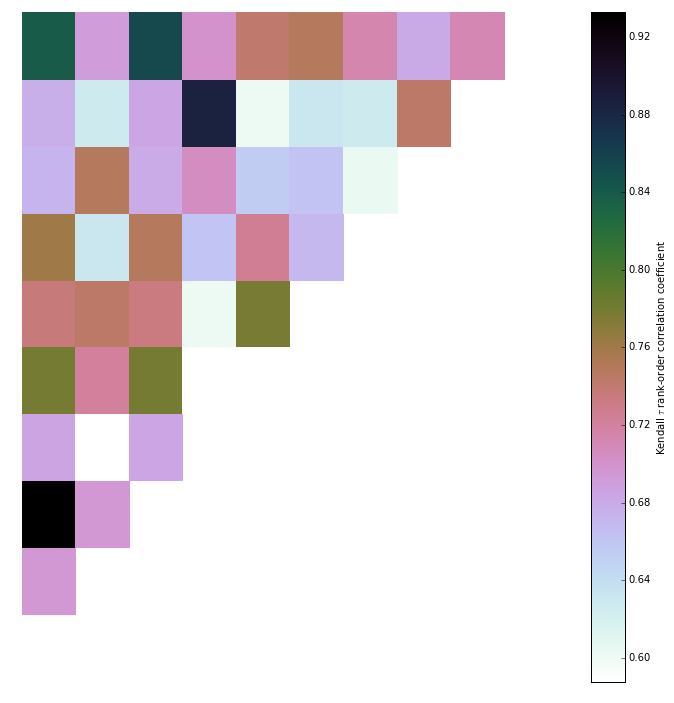

In [20]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 12)

masked_correlation = np.ma.array(correlation_matrix, mask=correlation_matrix == 0).T
plt.pcolor(masked_correlation, cmap=plt.cm.cubehelix_r)
plt.colorbar(label=r"Kendall $\tau$ rank-order correlation coefficient")
plt.ylim(None, 10)
plt.xlim(None, 10)
plt.axis('off')